# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer
import itertools  

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [6]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([[-10, 0, 10]]))
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([[1000, 0, 0]]))
assert np.isclose(probs[0, 0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([[-5, 0, 5], [-4, 0, 6]]))
linear_classifer.cross_entropy_loss(probs, [1, 2])

2.5046407076661206

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [8]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([[1, 0, 0]]), [[1]])
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, [[1]]), np.array([[1, 0, 0]], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [9]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(17)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# # Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [17]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [18]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [128]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.608786
Epoch 1, loss: 2.578784
Epoch 2, loss: 2.550954
Epoch 3, loss: 2.526245
Epoch 4, loss: 2.505394
Epoch 5, loss: 2.483122
Epoch 6, loss: 2.467298
Epoch 7, loss: 2.451356
Epoch 8, loss: 2.435842
Epoch 9, loss: 2.424889


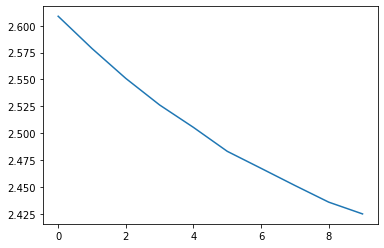

In [129]:
# let's look at the loss history!
plt.plot(loss_history)

In [130]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.115
Epoch 0, loss: 2.411435
Epoch 1, loss: 2.402383
Epoch 2, loss: 2.392385
Epoch 3, loss: 2.384350
Epoch 4, loss: 2.376266
Epoch 5, loss: 2.370571
Epoch 6, loss: 2.363494
Epoch 7, loss: 2.358460
Epoch 8, loss: 2.353469
Epoch 9, loss: 2.348225
Epoch 10, loss: 2.343689
Epoch 11, loss: 2.340393
Epoch 12, loss: 2.336975
Epoch 13, loss: 2.334680
Epoch 14, loss: 2.330778
Epoch 15, loss: 2.328536
Epoch 16, loss: 2.325855
Epoch 17, loss: 2.323803
Epoch 18, loss: 2.321549
Epoch 19, loss: 2.320268
Epoch 20, loss: 2.318411
Epoch 21, loss: 2.316635
Epoch 22, loss: 2.314989
Epoch 23, loss: 2.314042
Epoch 24, loss: 2.314574
Epoch 25, loss: 2.312237
Epoch 26, loss: 2.310462
Epoch 27, loss: 2.311160
Epoch 28, loss: 2.310537
Epoch 29, loss: 2.309730
Epoch 30, loss: 2.309156
Epoch 31, loss: 2.308272
Epoch 32, loss: 2.307523
Epoch 33, loss: 2.307544
Epoch 34, loss: 2.307470
Epoch 35, loss: 2.305915
Epoch 36, loss: 2.305841
Epoch 37, loss: 2.306043
Epoch 38, loss: 2.305413
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [240]:
num_epochs = 200
batch_size = 300
learning_rates = [3e-2, 1e-2, 1e-3, 1e-4]
reg_strengths = [1e-3, 1e-4, 1e-5]

# dict for saving accuracy results
accuracy_dict = dict()

# split array on train and test arrays
np.random.seed(17)
num_train = train_X.shape[0]
shuffled_indices = np.arange(num_train)
np.random.shuffle(shuffled_indices)
split = int(num_train*0.7)
train_indices = shuffled_indices[:split]
test_indices = shuffled_indices[split:]

for i in list(itertools.product(learning_rates, reg_strengths)):
    acc_list = list()
    # initialize Linear Classifier
    classifier = linear_classifer.LinearSoftmaxClassifier()
    classifier.fit(train_X[train_indices], train_y[train_indices], epochs=num_epochs, learning_rate=i[0], 
                   batch_size=batch_size, reg=i[1])
    # make a prediction
    pred = classifier.predict(train_X[test_indices])
    accuracy = multiclass_accuracy(pred, train_y[test_indices])
    accuracy_dict[i] = (accuracy, classifier, i[0], i[1])

sort_accuracy_dict = {k: v for k, v in sorted(accuracy_dict.items(), key=lambda item: item[1][0], reverse=True)}
best_accuracy = list(sort_accuracy_dict.values())[0][0]
best_classifier = list(sort_accuracy_dict.values())[0][1]
best_learning_rate = list(sort_accuracy_dict.values())[0][2]
best_reg_strength = list(sort_accuracy_dict.values())[0][3]

print(f'Best accuracy is {best_accuracy} for Linear Classifier with Learning Rate {best_learning_rate} and ' \
      f'Reg Strength {best_reg_strength}')  

test_pred = best_classifier.predict(val_X)
validation_accuracy = multiclass_accuracy(test_pred, val_y)
print(f'Linear softmax classifier validation set accuracy: {validation_accuracy}')

Epoch 0, loss: 2.303107
Epoch 1, loss: 2.298352
Epoch 2, loss: 2.291409
Epoch 3, loss: 2.321569
Epoch 4, loss: 2.298574
Epoch 5, loss: 2.298739
Epoch 6, loss: 2.284277
Epoch 7, loss: 2.308537
Epoch 8, loss: 2.290149
Epoch 9, loss: 2.295892
Epoch 10, loss: 2.301409
Epoch 11, loss: 2.293976
Epoch 12, loss: 2.304407
Epoch 13, loss: 2.303759
Epoch 14, loss: 2.288359
Epoch 15, loss: 2.288554
Epoch 16, loss: 2.294052
Epoch 17, loss: 2.284230
Epoch 18, loss: 2.290522
Epoch 19, loss: 2.288011
Epoch 20, loss: 2.286332
Epoch 21, loss: 2.279167
Epoch 22, loss: 2.275416
Epoch 23, loss: 2.303829
Epoch 24, loss: 2.282042
Epoch 25, loss: 2.273066
Epoch 26, loss: 2.283080
Epoch 27, loss: 2.282230
Epoch 28, loss: 2.264282
Epoch 29, loss: 2.278269
Epoch 30, loss: 2.286192
Epoch 31, loss: 2.277216
Epoch 32, loss: 2.288335
Epoch 33, loss: 2.277958
Epoch 34, loss: 2.266385
Epoch 35, loss: 2.278299
Epoch 36, loss: 2.270331
Epoch 37, loss: 2.266881
Epoch 38, loss: 2.271995
Epoch 39, loss: 2.273577
Epoch 40, 

Epoch 140, loss: 2.237859
Epoch 141, loss: 2.234055
Epoch 142, loss: 2.239790
Epoch 143, loss: 2.229586
Epoch 144, loss: 2.232246
Epoch 145, loss: 2.251027
Epoch 146, loss: 2.226108
Epoch 147, loss: 2.236912
Epoch 148, loss: 2.240498
Epoch 149, loss: 2.230324
Epoch 150, loss: 2.233000
Epoch 151, loss: 2.233503
Epoch 152, loss: 2.230587
Epoch 153, loss: 2.233577
Epoch 154, loss: 2.241310
Epoch 155, loss: 2.226446
Epoch 156, loss: 2.224038
Epoch 157, loss: 2.230352
Epoch 158, loss: 2.234371
Epoch 159, loss: 2.233152
Epoch 160, loss: 2.232825
Epoch 161, loss: 2.228742
Epoch 162, loss: 2.229542
Epoch 163, loss: 2.225186
Epoch 164, loss: 2.232754
Epoch 165, loss: 2.226924
Epoch 166, loss: 2.216933
Epoch 167, loss: 2.246819
Epoch 168, loss: 2.217168
Epoch 169, loss: 2.240339
Epoch 170, loss: 2.239872
Epoch 171, loss: 2.221388
Epoch 172, loss: 2.223244
Epoch 173, loss: 2.235949
Epoch 174, loss: 2.224187
Epoch 175, loss: 2.237053
Epoch 176, loss: 2.236634
Epoch 177, loss: 2.226368
Epoch 178, l

Epoch 86, loss: 2.280259
Epoch 87, loss: 2.274035
Epoch 88, loss: 2.273790
Epoch 89, loss: 2.270735
Epoch 90, loss: 2.273006
Epoch 91, loss: 2.278108
Epoch 92, loss: 2.275779
Epoch 93, loss: 2.273482
Epoch 94, loss: 2.271664
Epoch 95, loss: 2.270561
Epoch 96, loss: 2.268475
Epoch 97, loss: 2.266793
Epoch 98, loss: 2.270103
Epoch 99, loss: 2.277588
Epoch 100, loss: 2.267241
Epoch 101, loss: 2.271655
Epoch 102, loss: 2.271625
Epoch 103, loss: 2.264223
Epoch 104, loss: 2.269894
Epoch 105, loss: 2.267861
Epoch 106, loss: 2.262173
Epoch 107, loss: 2.273339
Epoch 108, loss: 2.267378
Epoch 109, loss: 2.264850
Epoch 110, loss: 2.262110
Epoch 111, loss: 2.273860
Epoch 112, loss: 2.273246
Epoch 113, loss: 2.267817
Epoch 114, loss: 2.273498
Epoch 115, loss: 2.265580
Epoch 116, loss: 2.263189
Epoch 117, loss: 2.268452
Epoch 118, loss: 2.263874
Epoch 119, loss: 2.265668
Epoch 120, loss: 2.264145
Epoch 121, loss: 2.266295
Epoch 122, loss: 2.265552
Epoch 123, loss: 2.267768
Epoch 124, loss: 2.270805


Epoch 30, loss: 2.290979
Epoch 31, loss: 2.296036
Epoch 32, loss: 2.292004
Epoch 33, loss: 2.290609
Epoch 34, loss: 2.289886
Epoch 35, loss: 2.291992
Epoch 36, loss: 2.292794
Epoch 37, loss: 2.289128
Epoch 38, loss: 2.289996
Epoch 39, loss: 2.288326
Epoch 40, loss: 2.290520
Epoch 41, loss: 2.285484
Epoch 42, loss: 2.290810
Epoch 43, loss: 2.291144
Epoch 44, loss: 2.285250
Epoch 45, loss: 2.281819
Epoch 46, loss: 2.289775
Epoch 47, loss: 2.286879
Epoch 48, loss: 2.284883
Epoch 49, loss: 2.275156
Epoch 50, loss: 2.290822
Epoch 51, loss: 2.292181
Epoch 52, loss: 2.289799
Epoch 53, loss: 2.290515
Epoch 54, loss: 2.284501
Epoch 55, loss: 2.281219
Epoch 56, loss: 2.286063
Epoch 57, loss: 2.278214
Epoch 58, loss: 2.287259
Epoch 59, loss: 2.280966
Epoch 60, loss: 2.281473
Epoch 61, loss: 2.285966
Epoch 62, loss: 2.285493
Epoch 63, loss: 2.281274
Epoch 64, loss: 2.279150
Epoch 65, loss: 2.278372
Epoch 66, loss: 2.284921
Epoch 67, loss: 2.275462
Epoch 68, loss: 2.277043
Epoch 69, loss: 2.283936


Epoch 157, loss: 2.295251
Epoch 158, loss: 2.294734
Epoch 159, loss: 2.296680
Epoch 160, loss: 2.296789
Epoch 161, loss: 2.296603
Epoch 162, loss: 2.296861
Epoch 163, loss: 2.297000
Epoch 164, loss: 2.295929
Epoch 165, loss: 2.296785
Epoch 166, loss: 2.295983
Epoch 167, loss: 2.296111
Epoch 168, loss: 2.295819
Epoch 169, loss: 2.296560
Epoch 170, loss: 2.296014
Epoch 171, loss: 2.295677
Epoch 172, loss: 2.295282
Epoch 173, loss: 2.294581
Epoch 174, loss: 2.295821
Epoch 175, loss: 2.295678
Epoch 176, loss: 2.296139
Epoch 177, loss: 2.294448
Epoch 178, loss: 2.294989
Epoch 179, loss: 2.294580
Epoch 180, loss: 2.296639
Epoch 181, loss: 2.294773
Epoch 182, loss: 2.296660
Epoch 183, loss: 2.294741
Epoch 184, loss: 2.295167
Epoch 185, loss: 2.295513
Epoch 186, loss: 2.295419
Epoch 187, loss: 2.295194
Epoch 188, loss: 2.294630
Epoch 189, loss: 2.295386
Epoch 190, loss: 2.293866
Epoch 191, loss: 2.294007
Epoch 192, loss: 2.294582
Epoch 193, loss: 2.294162
Epoch 194, loss: 2.294767
Epoch 195, l

Epoch 86, loss: 2.298720
Epoch 87, loss: 2.299289
Epoch 88, loss: 2.298581
Epoch 89, loss: 2.299343
Epoch 90, loss: 2.299312
Epoch 91, loss: 2.300282
Epoch 92, loss: 2.298472
Epoch 93, loss: 2.299937
Epoch 94, loss: 2.299384
Epoch 95, loss: 2.297827
Epoch 96, loss: 2.297546
Epoch 97, loss: 2.297911
Epoch 98, loss: 2.299537
Epoch 99, loss: 2.298697
Epoch 100, loss: 2.299527
Epoch 101, loss: 2.298711
Epoch 102, loss: 2.297722
Epoch 103, loss: 2.297924
Epoch 104, loss: 2.298528
Epoch 105, loss: 2.297649
Epoch 106, loss: 2.298229
Epoch 107, loss: 2.298381
Epoch 108, loss: 2.299304
Epoch 109, loss: 2.299306
Epoch 110, loss: 2.298288
Epoch 111, loss: 2.297015
Epoch 112, loss: 2.297764
Epoch 113, loss: 2.297159
Epoch 114, loss: 2.296448
Epoch 115, loss: 2.297651
Epoch 116, loss: 2.299011
Epoch 117, loss: 2.298542
Epoch 118, loss: 2.298095
Epoch 119, loss: 2.298001
Epoch 120, loss: 2.297704
Epoch 121, loss: 2.296996
Epoch 122, loss: 2.297450
Epoch 123, loss: 2.298674
Epoch 124, loss: 2.296163


Epoch 32, loss: 2.302018
Epoch 33, loss: 2.303014
Epoch 34, loss: 2.303228
Epoch 35, loss: 2.302390
Epoch 36, loss: 2.302762
Epoch 37, loss: 2.302872
Epoch 38, loss: 2.302847
Epoch 39, loss: 2.303434
Epoch 40, loss: 2.302528
Epoch 41, loss: 2.302568
Epoch 42, loss: 2.303155
Epoch 43, loss: 2.302681
Epoch 44, loss: 2.302129
Epoch 45, loss: 2.302365
Epoch 46, loss: 2.302825
Epoch 47, loss: 2.302104
Epoch 48, loss: 2.302720
Epoch 49, loss: 2.302101
Epoch 50, loss: 2.302033
Epoch 51, loss: 2.302662
Epoch 52, loss: 2.302787
Epoch 53, loss: 2.302824
Epoch 54, loss: 2.302816
Epoch 55, loss: 2.302396
Epoch 56, loss: 2.302925
Epoch 57, loss: 2.302745
Epoch 58, loss: 2.302798
Epoch 59, loss: 2.302387
Epoch 60, loss: 2.303223
Epoch 61, loss: 2.303310
Epoch 62, loss: 2.303585
Epoch 63, loss: 2.302210
Epoch 64, loss: 2.302231
Epoch 65, loss: 2.302306
Epoch 66, loss: 2.302373
Epoch 67, loss: 2.302366
Epoch 68, loss: 2.301889
Epoch 69, loss: 2.302779
Epoch 70, loss: 2.303142
Epoch 71, loss: 2.301866


Epoch 171, loss: 2.302339
Epoch 172, loss: 2.302226
Epoch 173, loss: 2.300752
Epoch 174, loss: 2.301516
Epoch 175, loss: 2.301670
Epoch 176, loss: 2.301001
Epoch 177, loss: 2.301464
Epoch 178, loss: 2.301498
Epoch 179, loss: 2.302499
Epoch 180, loss: 2.301390
Epoch 181, loss: 2.301651
Epoch 182, loss: 2.301881
Epoch 183, loss: 2.301675
Epoch 184, loss: 2.302780
Epoch 185, loss: 2.302471
Epoch 186, loss: 2.302040
Epoch 187, loss: 2.302347
Epoch 188, loss: 2.301977
Epoch 189, loss: 2.302104
Epoch 190, loss: 2.301422
Epoch 191, loss: 2.301339
Epoch 192, loss: 2.300849
Epoch 193, loss: 2.301582
Epoch 194, loss: 2.302007
Epoch 195, loss: 2.301625
Epoch 196, loss: 2.301553
Epoch 197, loss: 2.301779
Epoch 198, loss: 2.301531
Epoch 199, loss: 2.301584
Best accuracy is 0.19555555555555557 for Linear Classifier with Learning Rate 0.01 and Reg Strength 0.001
Linear softmax classifier validation set accuracy: 0.206


# Какой же точности мы добились на тестовых данных?

In [241]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print(f'Linear softmax classifier test set accuracy: {test_accuracy}')

Linear softmax classifier test set accuracy: 0.182
